In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LatitudeFormatter, LongitudeFormatter
import dask
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
from scipy.stats import ttest_ind
from nzmeltwater.util import cleanocn
from xesmf import Regridder

dask.config.set(scheduler="single-threaded")

mpl.rcParams["figure.figsize"] = 6, 4
mpl.rcParams["font.size"] = 12

In [2]:
droot = Path("../data/processed/HadGEM3-GC31-LL")

variables = ["uas", "vas"]

expts = ["historical", "ssp585"]

In [3]:
def rectilinear_regrid(dsin, dsout):
    regridder = Regridder(dsin.to_dataset(), dsout.to_dataset(), method="bilinear", periodic=True)
    da_r = regridder(dsin)

    return da_r

In [6]:
ctrldata = {}
ctrldataens = {}

for exp in expts:
    print(exp)
    ctrldata[exp] = {}
    ctrldataens[exp] = {}
    for var in variables:
        print(f"\t{var}")
        
        if exp == "historical":
            histdir = droot.joinpath("historical", "Amon", var)
            sspdir = droot.joinpath("ssp245", "Amon", var)

            tspan = slice("2015-01", "2020-12")

            histfiles = sorted(list(histdir.glob("*3_gn*.nc")))
            nch = list(histdir.glob("*ens_gn*.nc"))[0]
            ensmem = [f.name.split("_")[4] for f in histfiles]

            dshist = xr.open_mfdataset(
                histfiles, combine="nested", concat_dim="ensmem", parallel=True
            )

            dshist = dshist.assign_coords({"ensmem": ("ensmem", ensmem)})
            dahist = dshist[var].sel(time=slice("1992-01", "2014-12"))
            
            dsh = xr.open_dataset(nch)
            dah = dsh[var].sel(time=slice("1992-01", "2014-12"))
        else:
            sspdir = droot.joinpath("ssp585", "Amon", var)
            tspan = slice("2015-01", "2100-12")

        sspfiles = sorted(list(sspdir.glob("*3_gn*.nc")))
        ncs = list(sspdir.glob("*ens_gn*.nc"))[0]
        ensmem = [f.name.split("_")[4] for f in sspfiles]

        dsssp = xr.open_mfdataset(
            sspfiles, combine="nested", concat_dim="ensmem", parallel=True
        )

        dsssp = dsssp.assign_coords({"ensmem": ("ensmem", ensmem)})
        dassp = dsssp[var].sel(time=tspan)
        
        dss = xr.open_dataset(ncs)
        das = dss[var].sel(time=tspan)

        if exp == "historical":
            dac = xr.concat((dahist, dassp), dim="time")
            dacens = xr.concat((dah, das), dim="time")
        else:
            dac = dassp
            dacens = das
            
        if var == "uas":
            ctrldata[exp][var] = dac
            ctrldataens[exp][var] = dacens
        else:
            ctrldata[exp][var] = rectilinear_regrid(dac.compute(), ctrldata[exp]["uas"].compute())
            ctrldataens[exp][var] = rectilinear_regrid(dacens.compute(), ctrldataens[exp]["uas"].compute())

    ctrldata[exp]["wind"] = np.sqrt(ctrldata[exp]["uas"]**2 + ctrldata[exp]["vas"]**2)
    ctrldataens[exp]["wind"] = np.sqrt(ctrldataens[exp]["uas"]**2 + ctrldataens[exp]["vas"]**2)

historical
	uas
	vas
ssp585
	uas
	vas


In [7]:
sofdata = {}
sofdataens = {}
for exp in expts:
    print(exp)
    sofdata[exp] = {}
    sofdataens[exp] = {}
    for var in variables:
        if exp == "historical":
            sofdir = droot.joinpath("hist-antwater-92-11", "Amon", var)
        else:
            sofdir = droot.joinpath("ssp585-ismip6-water", "Amon", var)

        soffiles = sorted(list(sofdir.glob("*3_gn*.nc")))
        ncsof = list(sofdir.glob("*ens_gn*.nc"))[0]

        ensmem = [f.name.split("_")[4] for f in soffiles]

        dssof = cleanocn(
            xr.open_mfdataset(
                soffiles, combine="nested", concat_dim="ensmem", parallel=True
            )
        )

        dssof = dssof.assign_coords({"ensmem": ("ensmem", ensmem)})
        
        dss = cleanocn(xr.open_dataset(ncsof))

        if var == "uas":
            sofdata[exp][var] = dssof[var]
            sofdataens[exp][var] = dss[var]
        else:
            sofdata[exp][var] = rectilinear_regrid(dssof[var].compute(), sofdata[exp]["uas"].compute())
            sofdataens[exp][var] = rectilinear_regrid(dss[var].compute(), sofdataens[exp]["uas"].compute())

    sofdata[exp]["wind"] = np.sqrt(sofdata[exp]["uas"]**2 + sofdata[exp]["vas"]**2)
    sofdataens[exp]["wind"] = np.sqrt(sofdataens[exp]["uas"]**2 + sofdataens[exp]["vas"]**2)

historical
ssp585


In [8]:
def stattest2d(ctrl, expt):
    tstat, pval = ttest_ind(ctrl, expt)

    xpval = xr.DataArray(
        pval,
        coords={
            "lat": ("lat", ctrl.lat.data),
            "lon": ("lon", ctrl.lon.data),
        },
        dims=["lat", "lon"],
    )

    tanom = (expt - ctrl).mean("year")

    return xpval, tanom

In [9]:
anomdict = {}
pvaldict = {}

for exp in expts:
    print(exp)
    anomdict[exp] = {}
    pvaldict[exp] = {}
    for var in ["uas", "vas", "wind"]:
        if exp == "historical":
            tspan = slice("2011-01", "2020-12")
        else:
            tspan = slice("2071-01", "2100-12")

        dac_an = (
            ctrldata[exp][var]
            .sel(ensmem=sofdata[exp][var].ensmem, time=tspan)
            .groupby("time.year")
            .mean(("time", "ensmem"))
            .compute()
        )
        dasof_an = (
            sofdata[exp][var]
            .sel(time=tspan)
            .groupby("time.year")
            .mean(("time", "ensmem"))
            .compute()
        )

        pval, anom = stattest2d(dac_an, dasof_an)

        anomdict[exp][var] = anom
        pvaldict[exp][var] = pval

historical
ssp585


<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\D'
/dev/shm/jobs/51562609/ipykernel_22417/465928696.py:14: SyntaxWarning: invalid escape sequence '\D'
  cbar_kwargs={"label": "$\Delta$U [m s$^{-1}$]", "extend": "both"},


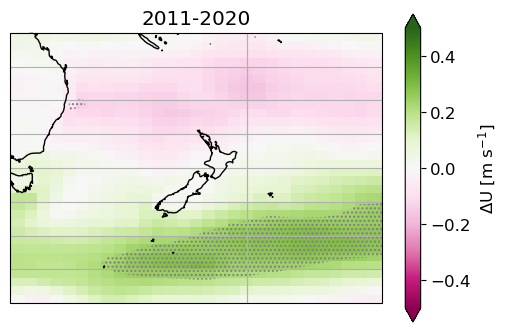

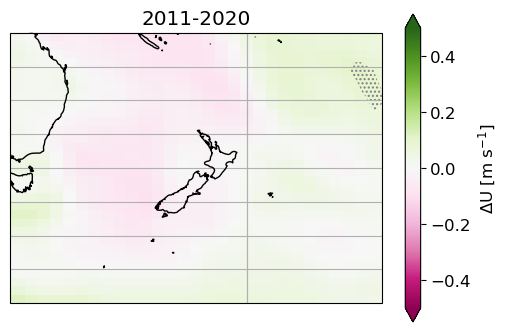

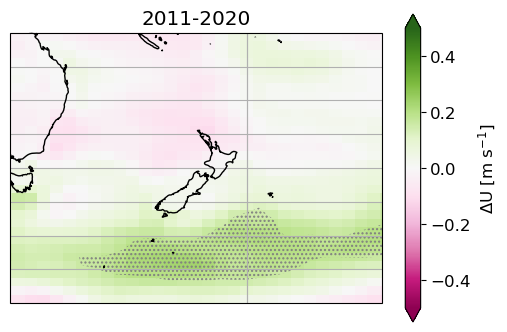

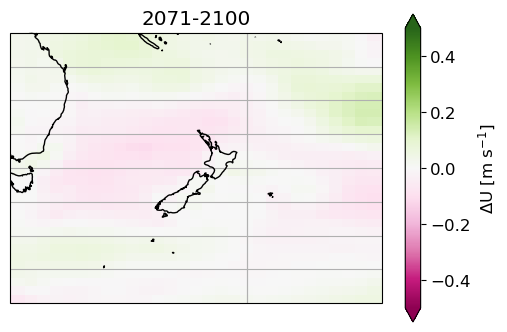

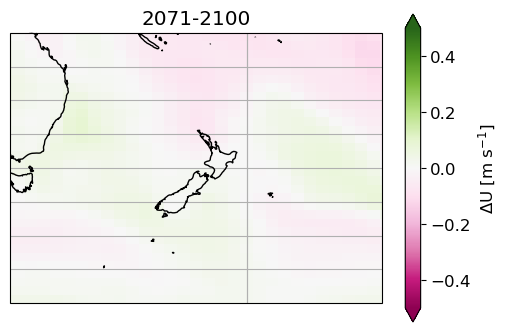

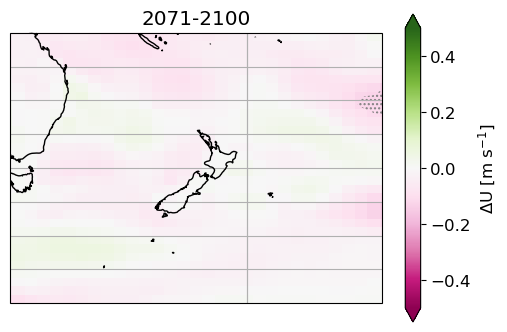

In [10]:
for exp in expts:
    for var in ["uas", "vas", "wind"]:
        fig = plt.figure()
        axs = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
        axs.coastlines(zorder=101)
        axs.gridlines(zorder=102)
        axs.set_extent([145, 200, -60, -20], crs=ccrs.PlateCarree())
        im = anomdict[exp][var].plot.pcolormesh(
            "lon",
            "lat",
            ax=axs,
            transform=ccrs.PlateCarree(),
            cmap="PiYG",
            cbar_kwargs={"label": "$\Delta$U [m s$^{-1}$]", "extend": "both"},
        )
        im.set_clim(-0.5, 0.5)

        levels = [0, 0.05, 0.1, 1]
        cs = pvaldict[exp][var].plot.contourf(
            "lon",
            "lat",
            ax=axs,
            transform=ccrs.PlateCarree(),
            levels=levels,
            hatches=["....", "", ""],
            colors="none",
            add_colorbar=False,
        )

        cs.set_edgecolor("tab:gray")
        cs.set_linewidth(0.0)

        if exp == "historical":
            axs.set_title("2011-2020")
        else:
            axs.set_title("2071-2100")

        fig.savefig(
            f"../figures/{var}_sofia_tier2_{exp}_nz.png", bbox_inches="tight", dpi=300
        )

In [11]:
def seas_subset(data):
    data_seas = data.resample(time="Q-FEB").mean("time").compute()
    data_seas = data_seas.isel(time=slice(1, -1))
    mam = data_seas.isel(time=slice(0, None, 4)).groupby("time.year").mean("time")
    jja = data_seas.isel(time=slice(1, None, 4)).groupby("time.year").mean("time")
    son = data_seas.isel(time=slice(2, None, 4)).groupby("time.year").mean("time")
    djf = data_seas.isel(time=slice(3, None, 4)).groupby("time.year").mean("time")

    out = xr.concat([djf, mam, jja, son], dim="season")
    out = out.assign_coords({"season": ("season", ["DJF", "MAM", "JJA", "SON"])})

    return out

In [12]:
def stattestseas(ctrl, expt):
    tstat, pval = ttest_ind(ctrl, expt, axis=0)

    coords = {
        "lat": ("lat", ctrl.lat.data),
        "lon": ("lon", ctrl.lon.data),
    }

    xpval = xr.DataArray(pval, dims=("lat", "lon"), coords=coords)

    tanom = (expt - ctrl).mean("year")

    return xpval, tanom

In [13]:
anomdictseas = {}
pvaldictseas = {}

for exp in expts:
    print(exp)
    anomdictseas[exp] = {}
    pvaldictseas[exp] = {}
    for var in["uas", "vas", "wind"]:
        
        if exp == "historical":
            tspan = slice("2011-01", "2020-12")
        else:
            tspan = slice("2071-01", "2100-12")

        ctrl = seas_subset(
            ctrldata[exp][var].sel(ensmem=sofdata[exp][var].ensmem, time=tspan).mean("ensmem")
        )
        expt = seas_subset(sofdata[exp][var].sel(time=tspan).mean("ensmem"))

        tanom = xr.zeros_like(ctrl.mean("year"))
        pval = xr.zeros_like(ctrl.mean("year"))

        for n, seas in enumerate(ctrl.season.data):
            print(seas)
            tmpc = ctrl.sel(season=seas)
            tmpe = expt.sel(season=seas)

            if seas == "DJF":
                tmpc = tmpc.isel(year=slice(1, None))
                tmpe = tmpe.isel(year=slice(1, None))

            pval[n, ...], tanom[n, ...] = stattestseas(tmpc, tmpe)

        anomdictseas[exp][var] = tanom
        pvaldictseas[exp][var] = pval

historical


<string>:6: FutureWarning: 'Q-FEB' is deprecated and will be removed in a future version. Please use 'QE-FEB' instead of 'Q-FEB'.
<string>:6: FutureWarning: 'Q-FEB' is deprecated and will be removed in a future version. Please use 'QE-FEB' instead of 'Q-FEB'.


DJF
MAM
JJA
SON


<string>:6: FutureWarning: 'Q-FEB' is deprecated and will be removed in a future version. Please use 'QE-FEB' instead of 'Q-FEB'.
<string>:6: FutureWarning: 'Q-FEB' is deprecated and will be removed in a future version. Please use 'QE-FEB' instead of 'Q-FEB'.


DJF
MAM
JJA
SON


<string>:6: FutureWarning: 'Q-FEB' is deprecated and will be removed in a future version. Please use 'QE-FEB' instead of 'Q-FEB'.
<string>:6: FutureWarning: 'Q-FEB' is deprecated and will be removed in a future version. Please use 'QE-FEB' instead of 'Q-FEB'.


DJF
MAM
JJA
SON
ssp585


<string>:6: FutureWarning: 'Q-FEB' is deprecated and will be removed in a future version. Please use 'QE-FEB' instead of 'Q-FEB'.
<string>:6: FutureWarning: 'Q-FEB' is deprecated and will be removed in a future version. Please use 'QE-FEB' instead of 'Q-FEB'.


DJF
MAM
JJA
SON


<string>:6: FutureWarning: 'Q-FEB' is deprecated and will be removed in a future version. Please use 'QE-FEB' instead of 'Q-FEB'.
<string>:6: FutureWarning: 'Q-FEB' is deprecated and will be removed in a future version. Please use 'QE-FEB' instead of 'Q-FEB'.


DJF
MAM
JJA
SON


<string>:6: FutureWarning: 'Q-FEB' is deprecated and will be removed in a future version. Please use 'QE-FEB' instead of 'Q-FEB'.
<string>:6: FutureWarning: 'Q-FEB' is deprecated and will be removed in a future version. Please use 'QE-FEB' instead of 'Q-FEB'.


DJF
MAM
JJA
SON


<>:48: SyntaxWarning: invalid escape sequence '\D'
<>:48: SyntaxWarning: invalid escape sequence '\D'
/dev/shm/jobs/51562609/ipykernel_22417/4101654498.py:48: SyntaxWarning: invalid escape sequence '\D'
  cb.set_label("$\Delta$U [m s$^{-1}$]")


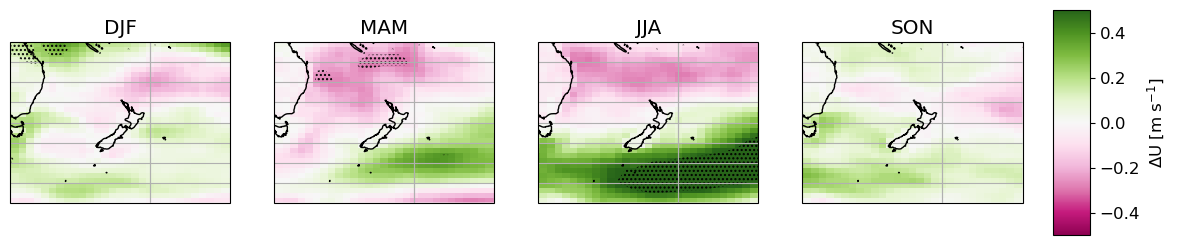

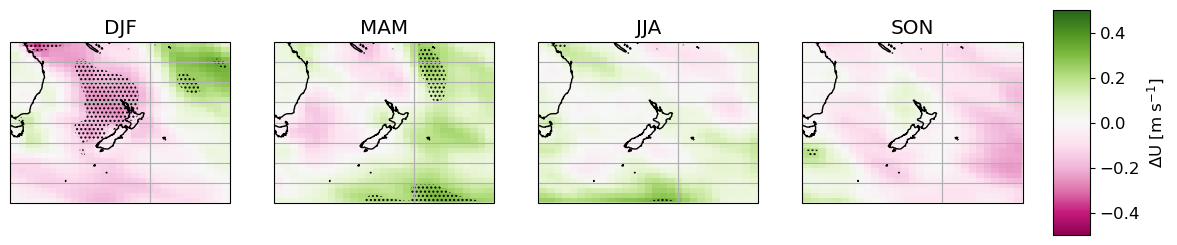

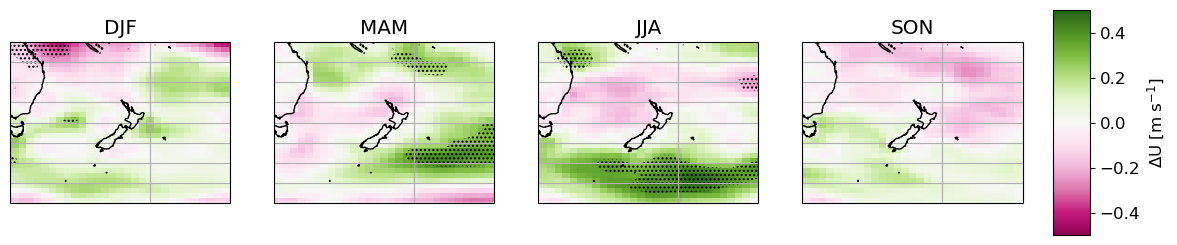

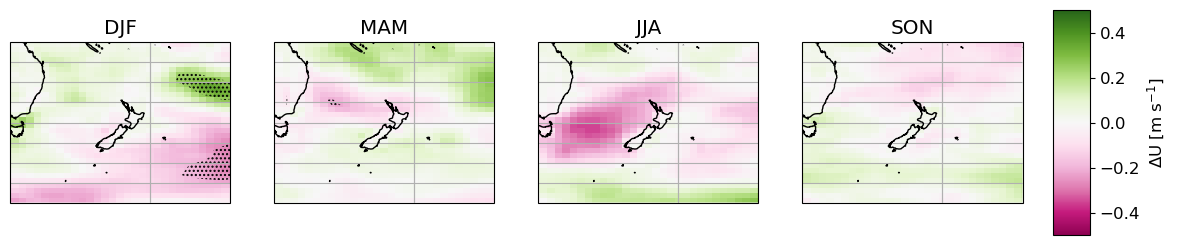

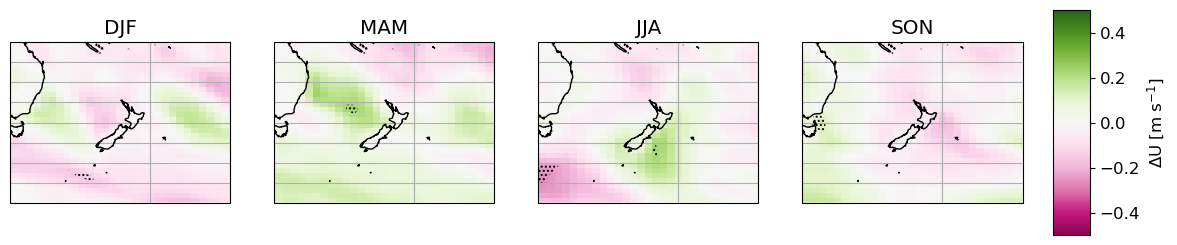

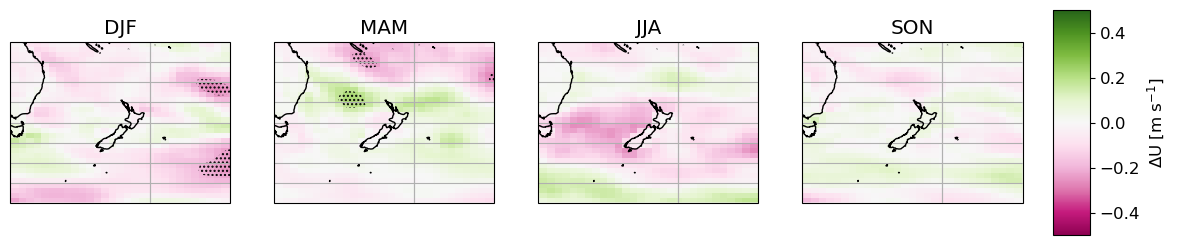

In [15]:
for exp in expts:
    for var in ["uas", "vas", "wind"]:
        fig, axs = plt.subplots(
            1,
            4,
            figsize=(15, 3),
            subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
        )

        for s, seas in enumerate(tanom.season.data):
            dplt = anomdictseas[exp][var].sel(season=seas)
            pplt = pvaldictseas[exp][var].sel(season=seas)

            axs[s].coastlines(zorder=200)
            axs[s].gridlines()
            axs[s].set_extent([145, 200, -60, -20], crs=ccrs.PlateCarree())
            im = dplt.plot.pcolormesh(
                "lon",
                "lat",
                ax=axs[s],
                transform=ccrs.PlateCarree(),
                cmap="PiYG",
                add_colorbar=False,
            )
            im.set_clim(-0.5, 0.5)

            levels = [0, 0.05, 0.1, 1]

            cs = pplt.plot.contourf(
                "lon",
                "lat",
                ax=axs[s],
                transform=ccrs.PlateCarree(),
                levels=levels,
                hatches=["....", "", ""],
                colors="none",
                add_colorbar=False,
            )

            cs.set_edgecolor("k")
            cs.set_linewidth(0.0)

            axs[s].set_title(seas)

        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.82, 0.12, 0.025, 0.75])
        cb = plt.colorbar(im, cax=cbar_ax)
        cb.set_label("$\Delta$U [m s$^{-1}$]")

        fig.savefig(
            f"../figures/{var}_seas_sofia_tier2_{exp}_nz.png",
            bbox_inches="tight",
            dpi=300,
        )

In [16]:
def plotnz(axs, data, pval, title):
    axs.coastlines(zorder=200)
    axs.set_extent([145, 200, -60, -20], crs=ccrs.PlateCarree())
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xlocator = mticker.FixedLocator([160, 180])
    gl.ylocator = mticker.FixedLocator([-45, -30, -15])
    gl.top_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.xformatter = LongitudeFormatter(dateline_direction_label=True)
    gl.xlabel_style = {'size': 8, 'color': 'k'}
    gl.ylabel_style = {'size': 8, 'color': 'k', 'rotation': 90}
    im = data.plot.pcolormesh(
        "lon",
        "lat",
        ax=axs,
        transform=ccrs.PlateCarree(),
        cmap="PiYG",
        add_colorbar=False,
    )
    im.set_clim(-0.5, 0.5)

    levels = [0, 0.05, 0.1, 1]

    cs = pval.plot.contourf(
        "lon",
        "lat",
        ax=axs,
        transform=ccrs.PlateCarree(),
        levels=levels,
        hatches=["....", "", ""],
        colors="none",
        add_colorbar=False,
    )

    cs.set_edgecolor("k")
    cs.set_linewidth(0.0)

    axs.set_title(title)

    return im

In [17]:
seasdict = {
    "DJF": "Summer (DJF)",
    "MAM": "Autumn (MAM)",
    "JJA": "Winter (JJA)",
    "SON": "Spring (SON)",
}

<>:39: SyntaxWarning: invalid escape sequence '\D'
<>:39: SyntaxWarning: invalid escape sequence '\D'
/dev/shm/jobs/51562609/ipykernel_22417/3863348163.py:39: SyntaxWarning: invalid escape sequence '\D'
  cb.set_label("$\Delta$U [m s$^{-1}$]")


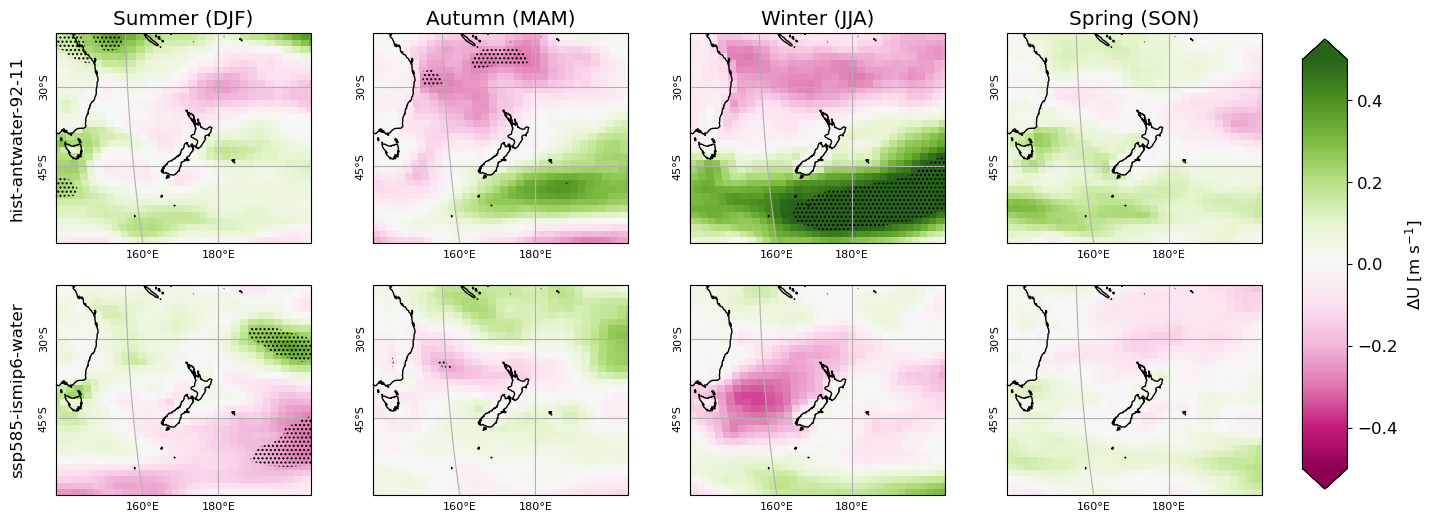

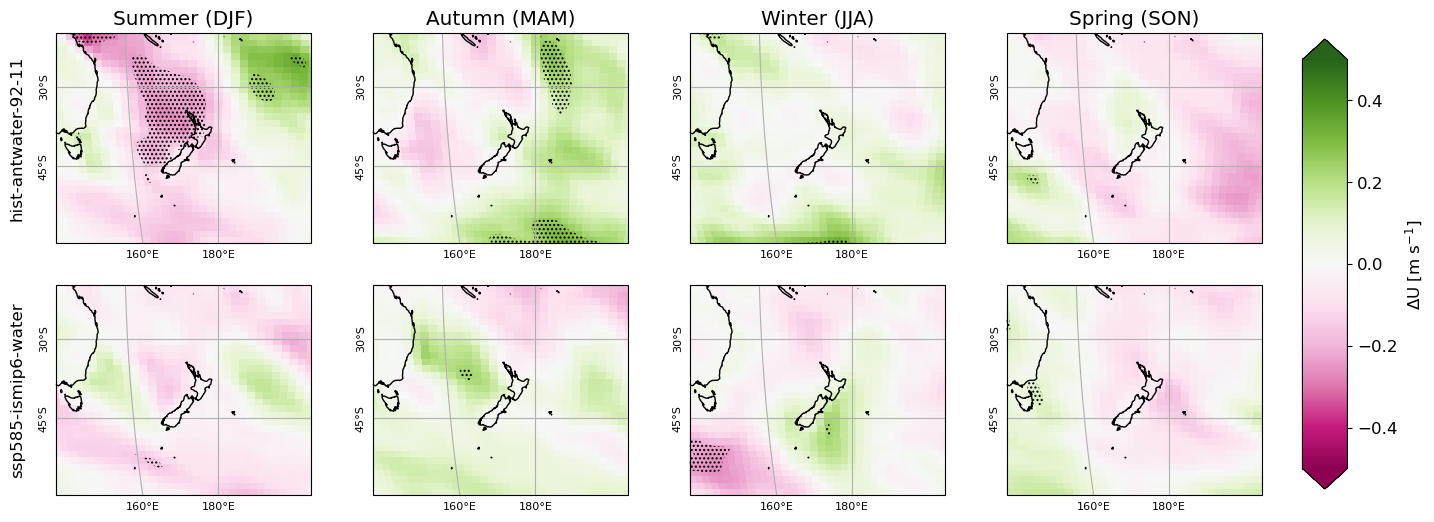

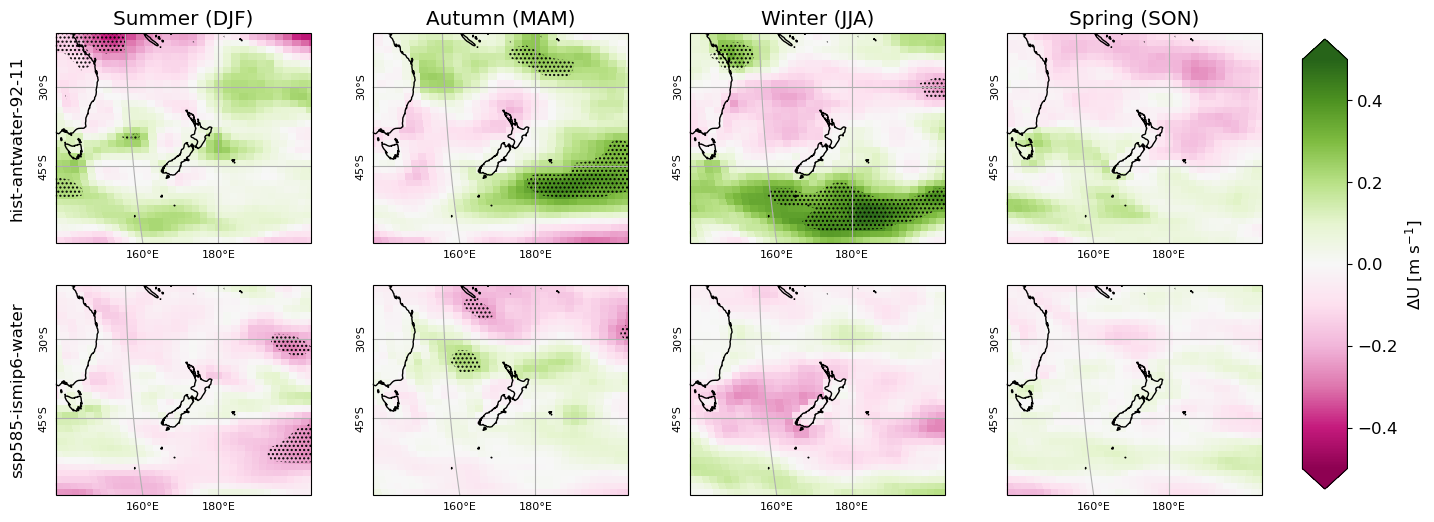

In [19]:
for var in ["uas", "vas", "wind"]:
    fig, axs = plt.subplots(
        2,
        4,
        figsize=(18, 6),
        subplot_kw={"projection": ccrs.Robinson(central_longitude=180)},
    )
    for n, exp in enumerate(expts):
        for s, seas in enumerate(tanom.season.data):
            dplt = anomdictseas[exp][var].sel(season=seas)
            pplt = pvaldictseas[exp][var].sel(season=seas)

            if n == 0:
                im = plotnz(axs[n, s], dplt, pplt, seasdict[seas])
            else:
                im = plotnz(axs[n, s], dplt, pplt, "")

    axs[0, 0].annotate(
        "hist-antwater-92-11",
        xy=(-0.15, 0.5),
        xycoords="axes fraction",
        rotation=90,
        ha="center",
        va="center",
    )

    axs[1, 0].annotate(
        "ssp585-ismip6-water",
        xy=(-0.15, 0.5),
        xycoords="axes fraction",
        rotation=90,
        ha="center",
        va="center",
    )

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.12, 0.025, 0.75])
    cb = plt.colorbar(im, cax=cbar_ax, extend="both")
    cb.set_label("$\Delta$U [m s$^{-1}$]")

    fig.savefig(
        f"../figures/{var}_seas_sofia_tier2_combined_nz.png",
        bbox_inches="tight",
        dpi=300,
    )